Meeting notes:
Story: how does community info encoded, when does it matter?

Do norms capture degree? or maybe if they're adding some centrality measure but is that reducing the performance? Where does the centrality info used in the random walks go? in the angles? LFR doesn't have correlation (no traiangles) Does norm capture degree? and angular info captures community? In correlated networks does it help to separate or combine both pieces of info?

Use core periphery structure networks an extreme example to test it out.
____________________________

Intuition: Community and degree info is orthogonal in Degree corrected Stochastic Block model, if we embed these networks using cos/sin/euclidean node2vec, do we see these orthogonal information go into angle and length respectively? 


100%|██████████████████████████████████████████████████████████████████████████████████| 6250/6250 [01:03<00:00, 98.30it/s, loss=1.18]
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and wil

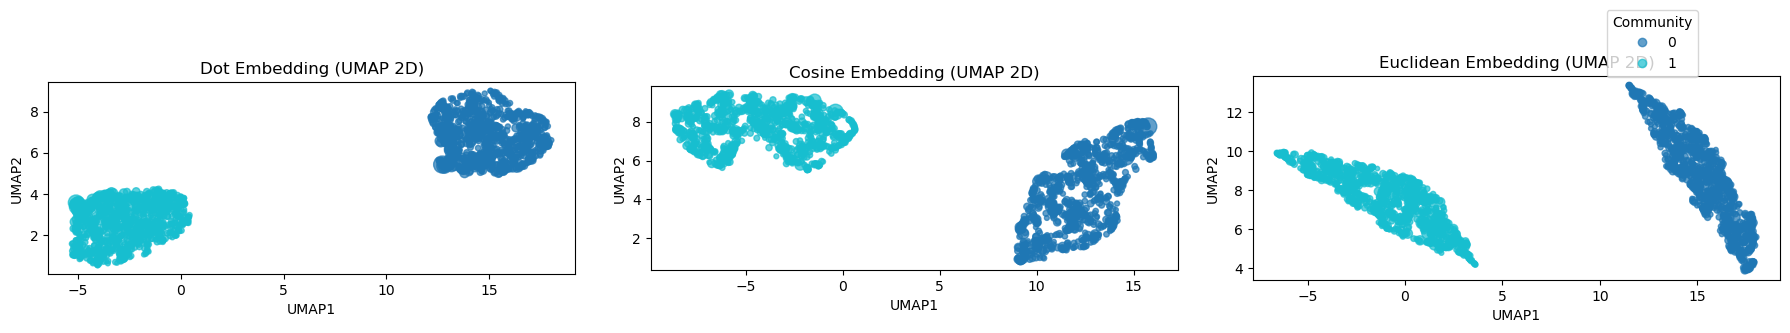

In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, normalized_mutual_info_score
from node2vecs import TorchNode2Vec

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.sparse as sp
import pandas as pd
import umap

import os
import random
import torch

# assuming calc_esim is already defined, and:
# embeddings: dict of name→(N×d) arrays,
# labels: length-N array in {0,1} for periphery and hubs assigned 0/1,
# n, H defined as before
def calc_esim(y, ypred):

    ylab, y = np.unique(y, return_inverse=True)
    ypredlab, ypred = np.unique(ypred, return_inverse=True)
    
    Ka, Kb = len(ylab), len(ypredlab)
    K = np.maximum(Ka, Kb)
    N = len(y)
    
    UA = sp.csr_matrix((np.ones_like(y), (np.arange(y.size), y)), shape=(N,K))
    UB = sp.csr_matrix((np.ones_like(ypred), (np.arange(ypred.size), ypred)), shape=(N, K))    
    
    nA = np.array(UA.sum(axis=0)).reshape(-1)
    nB = np.array(UB.sum(axis=0)).reshape(-1)

# nAB[i][j] is read as the number of elements that belong to ith ground truth label and jth predicrted label.
# nAB[1][0] = 1 For ground truth label with index 1 and predicted label 0 we have 1 element. i.e. 0000|1| vs 1110|0|

    nAB = (UA.T @ UB).toarray()
    nAB_rand = np.outer(nA, nB) / N
    
# assuming that each element has an equal probability of being assigned to any label,
# and the expected counts are calculated based on label frequencies.


    # Calc element-centric similarity
    Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    Q = 1 / np.maximum(Q, 1)
    S = np.sum(np.multiply(Q, (nAB**2))) / N
    
    # Calc the expected element-centric similarity for random partitions
    #Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    #Q = 1 / np.maximum(Q, 1)
    Srand = np.sum(np.multiply(Q, (nAB_rand**2))) / N
    Scorrected = (S - Srand) / (1 - Srand)
    return Scorrected





# # 1) Python built-ins
# random.seed(42)

# # 2) NumPy
# np.random.seed(42)

# # 3) PyTorch (affects Node2Vec's torch code)
# torch.manual_seed(42)
# torch.cuda.manual_seed_all(42)
# torch.use_deterministic_algorithms(True)            # make certain ops deterministic
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'   # if using CUDA

# # 4) scikit-learn / UMAP / other libs that take random_state
# UMAP_SEED     = 42
# KMEANS_SEED   = 42
# NODE2VEC_SEED = 42



# 1) Build a two-community core-periphery graph
def make_core_periphery_two_labels(
    n=100, H=4,
    p_in=0.1, p_out=0.005,
    p_hh=1, p_h_in=0.90, p_h_out=0.85
):
    G = nx.Graph()
    N = 2*n + H
    G.add_nodes_from(range(N))
    # peripheral communities
    for comm in (0,1):
        start = comm * n
        for u in range(start, start + n):
            for v in range(u+1, start + n):
                if np.random.rand() < p_in:
                    G.add_edge(u, v)
    # noise between communities
    for u in range(n):
        for v in range(n, 2*n):
            if np.random.rand() < p_out:
                G.add_edge(u, v)
    # hubs
    hubs = list(range(2*n, 2*n + H))
    # hub–hub core
    for i in range(H):
        for j in range(i+1, H):
            if np.random.rand() < p_hh:
                G.add_edge(hubs[i], hubs[j])
    # assign labels and hub biases
    labels = np.zeros(N, dtype=int)
    labels[n:2*n] = 1
    for idx, h in enumerate(hubs):
        home = idx % 2
        labels[h] = home
        # connect to home community
        for v in range(home*n, home*n + n):
            if np.random.rand() < p_h_in:
                G.add_edge(h, v)
        # connect to other community
        other = (1-home)*n
        for v in range(other, other + n):
            if np.random.rand() < p_h_out:
                G.add_edge(h, v)
    return G, labels

# Parameters


# n      = 200     # no of periphery nodes in each community
# H      = 50      # number of hubs in total network ( x/2 in each community)
# p_in   = 0.20    # fairly well‐connected periphery
# p_out  = 0.005   # almost no direct cross‐links
# p_hh   = 0.90    # hubs almost fully a clique
# p_h_in = 0.90    # strong bias into home community
# p_h_out= 0.70    # still lots of cross‐community hub edges
# vector_size = 32
# num_walks is self adjusted, and walk_length is default to 80

# n      = 200
# H      = 50
# p_in   = 0.15
# p_out  = 0.002
# p_hh   = 0.98
# p_h_in = 0.95
# p_h_out= 0.85
# vector_size = 32


# n      = 200
# H      = 50
# p_in   = 0.10
# p_out  = 0.0005
# p_hh   = 1.00
# p_h_in = 0.99
# p_h_out= 0.90
# vector_size = 32

n      = 200     # no of periphery nodes in each community
H      = 50      # number of hubs in total network ( x/2 in each community)
p_in   = 0.0    # fairly well‐connected periphery
p_out  = 0.0   # almost no direct cross‐links
p_hh   = 0.9   # hubs almost fully a clique
p_h_in = 1.0   # strong bias into home community
p_h_out= 0.5   # still lots of cross‐community hub edges
vector_size = 32

# 2) Generate graph and labels
#G, labels = make_core_periphery_two_labels(n, H, p_in, p_out, p_hh, p_h_in, p_h_out)


def make_dcsbm_extreme(
    n_per_block=200,
    alpha=2.5,
    theta_min=0.1,
    B_in=0.05,
    B_out=0.0005
):
    """
    Extreme 2‐block DCSBM:
      - n_per_block: number of nodes in each block
      - theta_i ~ Pareto(alpha) shifted+clipped at theta_min
      - B[0,0]=B[1,1]=B_in, B[0,1]=B[1,0]=B_out
    Returns: G, labels (0/1), theta array
    """
    N = 2 * n_per_block
    # 1) assign blocks
    labels = np.zeros(N, dtype=int)
    labels[n_per_block:] = 1

    # 2) draw heavy‐tailed theta
    raw = np.random.pareto(alpha, size=N) + 1
    theta = np.clip(raw, theta_min, None)

    # 3) build graph
    G = nx.Graph()
    G.add_nodes_from(range(N))
    for i in range(N):
        for j in range(i+1, N):
            p = theta[i] * theta[j] * (B_in if labels[i]==labels[j] else B_out)
            if np.random.rand() < p:
                G.add_edge(i, j)
    return G, labels, theta

# --- USAGE: drop this in place of your ring_of_stars call ---
n      = 1000
G, labels, theta = make_dcsbm_extreme(
    n_per_block=n,
    alpha=3,        # heavy tail
    theta_min=0.1,
    B_in=0.05,        # strong within‐block
    B_out=0.0005      # near zero across‐block
)

# now downstream is exactly as before:
# A = nx.to_scipy_sparse_array(G, format='csr')
# train embeddings = {‘dot’,‘cosine’,‘euclidean’} via TorchNode2Vec
# sample same/diff-community pairs from `labels`
# compute ROC‐AUC, ARI, ECS
# plot violin of norms (z‑scores or median ratios), etc.




# pos = nx.spring_layout(G)  # positions for all nodes
# plt.figure(figsize=(8, 6))
# nx.draw(G, pos, with_labels=True)
# #plt.title(f"Ring of {H} Stars, each with Leaves")
# plt.axis('off')
# plt.show()



# 3) Adjacency matrix
A = nx.to_scipy_sparse_array(G, format='csr')

# 4) Train embeddings
embeddings = {}
for metric in ['dot', 'cosine', 'euclidean']:
    model = TorchNode2Vec(
        vector_size=vector_size,
        similarity_metric=metric,
        device='cpu',
        num_workers=1
    )
    model.fit(A)
    embeddings[metric] = model.transform()

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA

deg_dict = dict(G.degree())
degrees  = np.array([deg_dict[i] for i in G.nodes()])

# Normalize for plotting (map min→20, max→200)
min_sz, max_sz = 10, 150
deg_norm = (degrees - degrees.min()) / (degrees.max() - degrees.min())
sizes    = min_sz + deg_norm * (max_sz - min_sz)

degrees.min(), degrees.max(), sizes.min(), sizes.max()

# 2) Embed plotting via 2D UMAP
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,   # tune between 5–50 for more local vs global structure
    min_dist=0.1,     # tune tighter clusters vs more spread
    random_state=42
    #n_jobs=6
)

from threadpoolctl import threadpool_limits


fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (metric, E) in zip(axes, embeddings.items()):
    # fit UMAP on this embedding
    
    with threadpool_limits(limits=1, user_api='blas'):
        Z = reducer.fit_transform(E)
        
    sc = ax.scatter(
        Z[:, 0], Z[:, 1],
        c=labels, cmap='tab10',
        s=sizes, alpha=0.7
    )
    ax.set_title(f"{metric.capitalize()} Embedding (UMAP 2D)")
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_aspect('equal', 'box')

# shared legend

fig.legend(
    *sc.legend_elements(),
    title="Community",
    loc='upper right',
    bbox_to_anchor=(0.95, 0.85)
)

plt.tight_layout()
plt.show()
 

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.cluster  import KMeans
from sklearn.metrics  import adjusted_rand_score
import scipy.sparse as sp

# --- assume: embeddings: dict→(N×d) arrays; labels: length‑N array in {0,1} ---
N = len(labels)
rng = np.random.default_rng(42)

# 1) build same/block and diff/block pairs
same = [(i,j) for i in range(N) for j in range(i+1,N) if labels[i]==labels[j]]
diff = [(i,j) for i in range(N) for j in range(i+1,N) if labels[i]!=labels[j]]
pos_idx = rng.choice(len(same), size=10000, replace=False)
neg_idx = rng.choice(len(diff), size=10000, replace=False)
pairs = np.array([same[i] for i in pos_idx] + [diff[i] for i in neg_idx])
y     = np.array([1]*10000 + [0]*10000)

# 2) ROC‑AUC for each embedding & metric
roc_records = {}
for name, E in embeddings.items():
    i_idx, j_idx = pairs[:,0], pairs[:,1]
    dots    = np.sum(E[i_idx]*E[j_idx], axis=1)
    norms   = np.linalg.norm(E, axis=1)
    cosines = dots / (norms[i_idx]*norms[j_idx] + 1e-12)
    norm_diff  = -np.abs(norms[i_idx] - norms[j_idx])
    E_unit     = E / (norms[:,None] + 1e-12)
    euc_on_norm= -np.linalg.norm(E_unit[i_idx] - E_unit[j_idx], axis=1)

    roc_records[name] = {
      'dot':        roc_auc_score(y, dots),
      'cosine':     roc_auc_score(y, cosines),
      'norm_diff':  roc_auc_score(y, norm_diff),
      'euc_on_norm':roc_auc_score(y, euc_on_norm)
    }

roc_df = pd.DataFrame.from_dict(roc_records, orient='index')
print("ROC‑AUC on DCSBM blocks:")
print(roc_df)


# 3) K‑Means clustering: ARI & element‑centric similarity
def calc_esim(y, ypred):
    ylab, y = np.unique(y, return_inverse=True)
    yplab, ypred = np.unique(ypred, return_inverse=True)
    Ka, Kb = len(ylab), len(yplab)
    K = max(Ka, Kb); N = len(y)
    UA = sp.csr_matrix((np.ones_like(y), (np.arange(N), y)), shape=(N,K))
    UB = sp.csr_matrix((np.ones_like(ypred), (np.arange(N), ypred)), shape=(N,K))
    nA = np.array(UA.sum(axis=0)).ravel()
    nB = np.array(UB.sum(axis=0)).ravel()
    nAB = (UA.T @ UB).toarray()
    nAB_rand = np.outer(nA, nB)/N
    Q = 1/np.maximum(np.maximum.outer(nA, nB),1)
    S     = (Q*(nAB**2)).sum()/N
    Srand = (Q*(nAB_rand**2)).sum()/N
    return (S - Srand)/(1 - Srand)

clus_records = {}
for name, E in embeddings.items():
    # 2‑cluster on embeddings
    km = KMeans(n_clusters=2, random_state=0).fit(E)
    ypred = km.labels_
    ari = adjusted_rand_score(labels, ypred)
    ecs = calc_esim(labels, ypred)
    clus_records[name] = {'ARI': ari, 'ECS': ecs}

clus_df = pd.DataFrame.from_dict(clus_records, orient='index')
print("\nClustering performance on DCSBM:")
print(clus_df)


ROC‑AUC on DCSBM blocks:
           dot  cosine  norm_diff  euc_on_norm
dot        1.0     1.0   0.495632          1.0
cosine     1.0     1.0   0.516183          1.0
euclidean  1.0     1.0   0.858139          1.0

Clustering performance on DCSBM:
           ARI  ECS
dot        1.0  1.0
cosine     1.0  1.0
euclidean  1.0  1.0


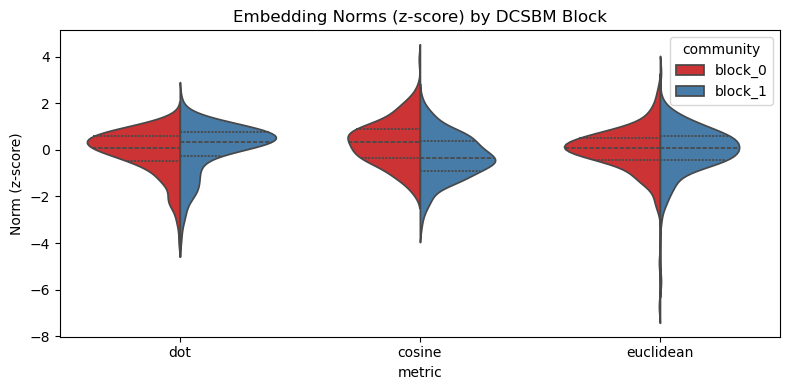

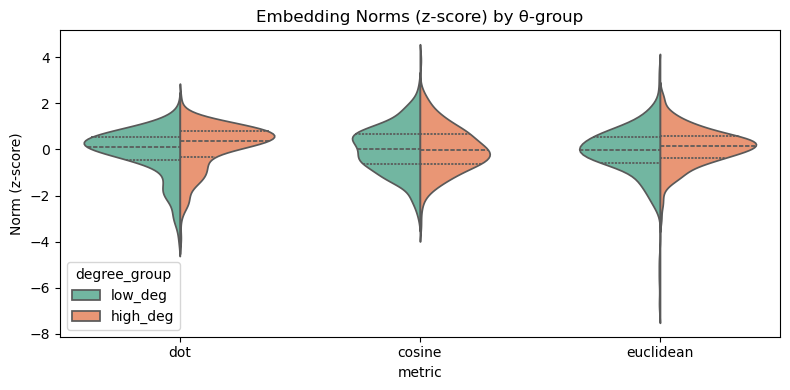

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assumes embeddings, labels, theta are defined ---

# 1) Build DataFrame with two ways to slice:
#    a) community = labels (0 or 1)
#    b) degree_group = high/low θ (split at median θ)
data = []
deg_cut = np.median(theta)
for metric, E in embeddings.items():
    norms       = np.linalg.norm(E, axis=1)
    mean_norm   = norms.mean()
    std_norm    = norms.std(ddof=0)
    median_norm = np.median(norms)
    for i, norm in enumerate(norms):
        z = (norm - mean_norm) / std_norm
        ratio = norm / median_norm
        data.append({
            'metric':       metric,
            'community':    f"block_{labels[i]}",
            'degree_group': 'high_deg' if theta[i] > deg_cut else 'low_deg',
            'z_score':      z,
            'median_ratio': ratio
        })
df = pd.DataFrame(data)

# 2) Violin by community
plt.figure(figsize=(8,4))
sns.violinplot(
    x='metric', y='z_score', hue='community',
    data=df, split=True, inner='quartile', palette='Set1'
)
plt.title("Embedding Norms (z‐score) by DCSBM Block")
plt.ylabel("Norm (z‐score)")
plt.tight_layout()
plt.show()

# 3) Violin by degree‐group
plt.figure(figsize=(8,4))
sns.violinplot(
    x='metric', y='z_score', hue='degree_group',
    data=df, split=True, inner='quartile', palette='Set2'
)
plt.title("Embedding Norms (z‐score) by θ‐group")
plt.ylabel("Norm (z‐score)")
plt.tight_layout()
plt.show()

In [11]:
from scipy.stats import ttest_ind, mannwhitneyu

total_leaves = leaves_per_hub * H

for metric, E in embeddings.items():
    norms    = np.linalg.norm(E, axis=1)
    per_norm = norms[:total_leaves]
    hub_norm = norms[total_leaves:]
    
    # parametric
    t_stat, p_t = ttest_ind(hub_norm, per_norm, equal_var=False)
    # non-parametric
    u_stat, p_u = mannwhitneyu(hub_norm, per_norm, alternative='two-sided')
    
    print(f"{metric:9s}  t-test p={p_t:.2e}   MWU p={p_u:.2e}")

def cohens_d(x,y):
    nx, ny = len(x), len(y)
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    pooled = np.sqrt(((nx-1)*vx + (ny-1)*vy) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled

for metric, E in embeddings.items():
    norms    = np.linalg.norm(E, axis=1)
    per_norm = norms[:total_leaves]
    hub_norm = norms[total_leaves:]
    d = cohens_d(hub_norm, per_norm)
    print(f"{metric:9s}  Cohen’s d = {d:.2f}")



dot        t-test p=2.73e-04   MWU p=2.81e-05
cosine     t-test p=4.57e-02   MWU p=2.66e-02
euclidean  t-test p=4.14e-01   MWU p=3.00e-01
dot        Cohen’s d = 3.65
cosine     Cohen’s d = 1.11
euclidean  Cohen’s d = 0.41


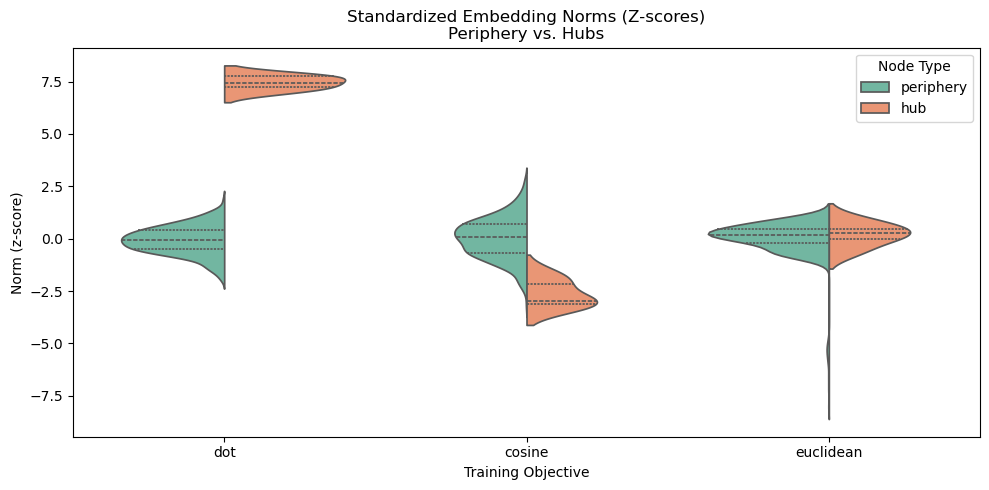

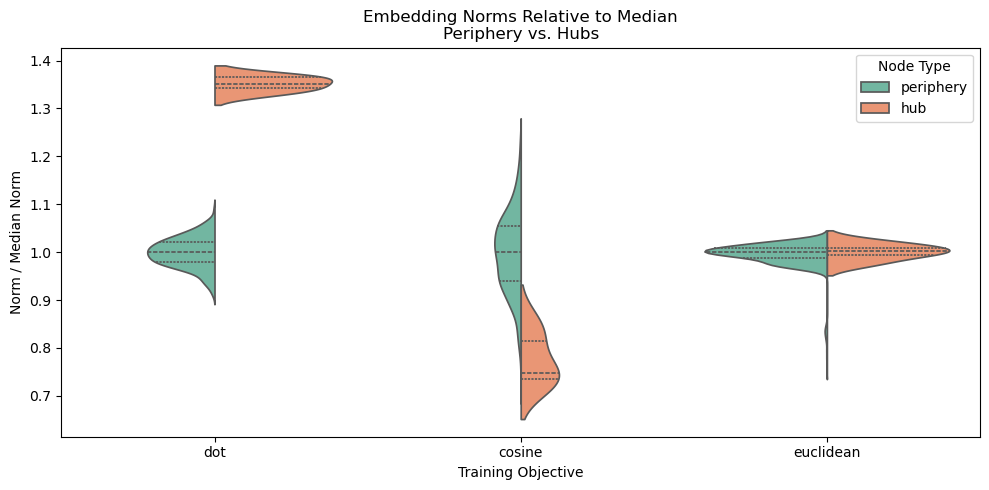

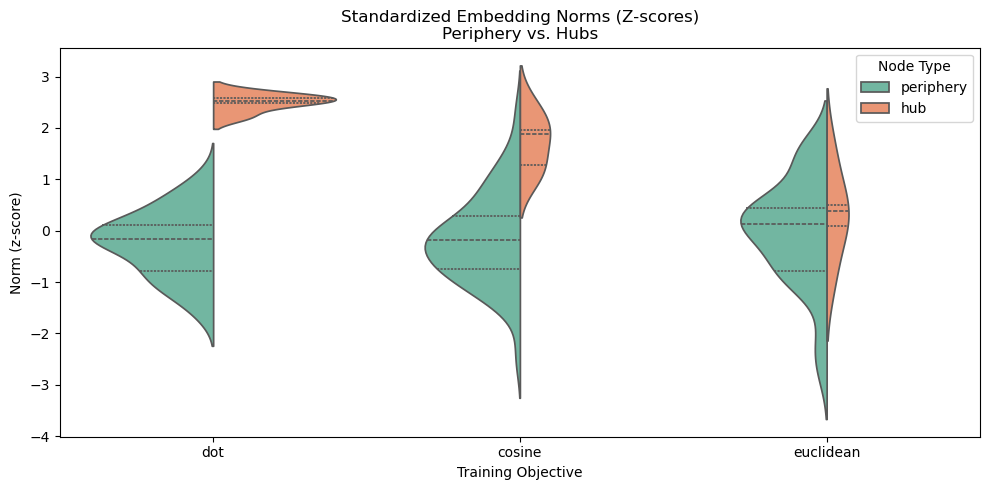

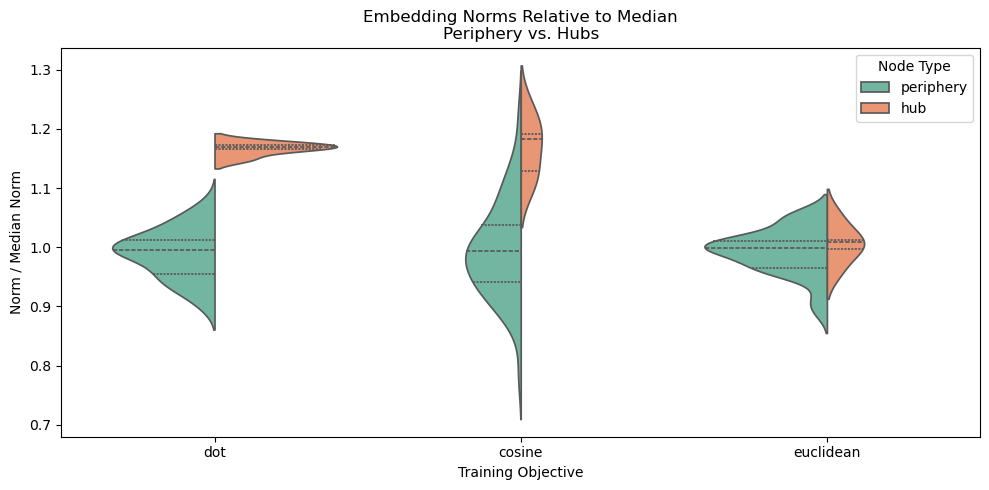

In [7]:
def make_dcsbm_extreme_params(
    n_per_block,
    alpha,       # Pareto tail – small α ⇒ heavier tail
    B_in,        # within‐block affinity
    B_out        # cross‐block affinity
):
    """
    Returns: G, labels, theta
    - labels ∈ {0,1}
    - theta_i ~ Pareto(alpha)+1
    - P(edge_ij) = clamp(theta_i θ_j * (B_in or B_out), 0,1)
    """
    N = 2 * n_per_block
    labels = np.zeros(N, int)
    labels[n_per_block:] = 1

    # heavy‐tailed degree params
    theta = np.random.pareto(alpha, size=N) + 1.0

    G = nx.Graph()
    G.add_nodes_from(range(N))
    for i in range(N):
        for j in range(i+1, N):
            p = theta[i]*theta[j] * (B_in if labels[i]==labels[j] else B_out)
            if np.random.rand() < p:
                G.add_edge(i, j)
    return G, labels, theta


scenarios = {
    'heavy‐degree, weak‐blocks': dict(alpha=1.5, B_in=0.01,  B_out=0.0001),
    'light‐degree, strong‐blocks': dict(alpha=5.0, B_in=0.1,   B_out=0.001),
    'both‐strong':                dict(alpha=1.5, B_in=0.1,   B_out=0.001),
    'both‐weak':                  dict(alpha=5.0, B_in=0.01,  B_out=0.0001),
}

results = []
for name, params in scenarios.items():
    G, labels, theta = make_dcsbm_extreme_params(
        n_per_block=200,
        alpha=params['alpha'],
        B_in=params['B_in'],
        B_out=params['B_out']
    )
    A = nx.to_scipy_sparse_array(G, format='csr')
    # train embeddings
    embeds = {}
    for metric in ['dot','cosine','euclidean']:
        m = TorchNode2Vec(vector_size=32,
                          similarity_metric=metric,
                          device='cpu', num_workers=1)
        m.fit(A)
        embeds[metric] = m.transform()

    # sample 10k same/block & 10k cross/block pairs
    N = len(labels)
    rng = np.random.default_rng(42)
    same = [(i,j) for i in range(N) for j in range(i+1,N) if labels[i]==labels[j]]
    diff = [(i,j) for i in range(N) for j in range(i+1,N) if labels[i]!=labels[j]]
    pos = rng.choice(len(same),  10000, replace=False)
    neg = rng.choice(len(diff), 10000, replace=False)
    pairs = np.array([same[i] for i in pos]+[diff[i] for i in neg])
    y     = np.array([1]*10000 + [0]*10000)

    # ROC‐AUC
    roc_rec = {'scenario':name}
    for metric,E in embeds.items():
        i_idx,j_idx = pairs[:,0], pairs[:,1]
        dots = (E[i_idx]*E[j_idx]).sum(axis=1)
        norms= np.linalg.norm(E,axis=1)
        cosines = dots/(norms[i_idx]*norms[j_idx]+1e-12)
        norm_diff = -np.abs(norms[i_idx]-norms[j_idx])
        E_unit = E/(norms[:,None]+1e-12)
        euc_on_norm = -np.linalg.norm(E_unit[i_idx]-E_unit[j_idx],axis=1)
        roc_rec[f"{metric}_dot"]        = roc_auc_score(y, dots)
        roc_rec[f"{metric}_cosine"]     = roc_auc_score(y, cosines)
        roc_rec[f"{metric}_norm_diff"]  = roc_auc_score(y, norm_diff)
        roc_rec[f"{metric}_euc_on_norm"]= roc_auc_score(y, euc_on_norm)

    # K‐Means clustering
    clus_rec = {'scenario':name}
    for metric,E in embeds.items():
        km     = KMeans(n_clusters=2, random_state=0).fit(E)
        ypred  = km.labels_
        ari    = adjusted_rand_score(labels, ypred)
        ecs    = calc_esim(labels, ypred)
        clus_rec[f"{metric}_ARI"] = ari
        clus_rec[f"{metric}_ECS"] = ecs

    # record
    record = {**roc_rec, **clus_rec}
    results.append(record)

df_results = pd.DataFrame(results)
print(df_results)


100%|█████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:11<00:00, 107.17it/s, loss=1.14]


                      scenario   dot_dot  dot_cosine  dot_norm_diff  \
0    heavy‐degree, weak‐blocks  1.000000    1.000000       0.501094   
1  light‐degree, strong‐blocks  1.000000    1.000000       0.497669   
2                  both‐strong  1.000000    1.000000       0.536401   
3                    both‐weak  0.940007    0.936418       0.499043   

   dot_euc_on_norm  cosine_dot  cosine_cosine  cosine_norm_diff  \
0         1.000000    1.000000       1.000000          0.508174   
1         1.000000    1.000000       1.000000          0.504948   
2         1.000000    1.000000       1.000000          0.508400   
3         0.936418    0.979194       0.972867          0.515947   

   cosine_euc_on_norm  euclidean_dot  euclidean_cosine  euclidean_norm_diff  \
0            1.000000       1.000000          1.000000             0.933617   
1            1.000000       1.000000          1.000000             0.980838   
2            1.000000       1.000000          1.000000             0.74

100%|█████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:11<00:00, 106.18it/s, loss=1.13]


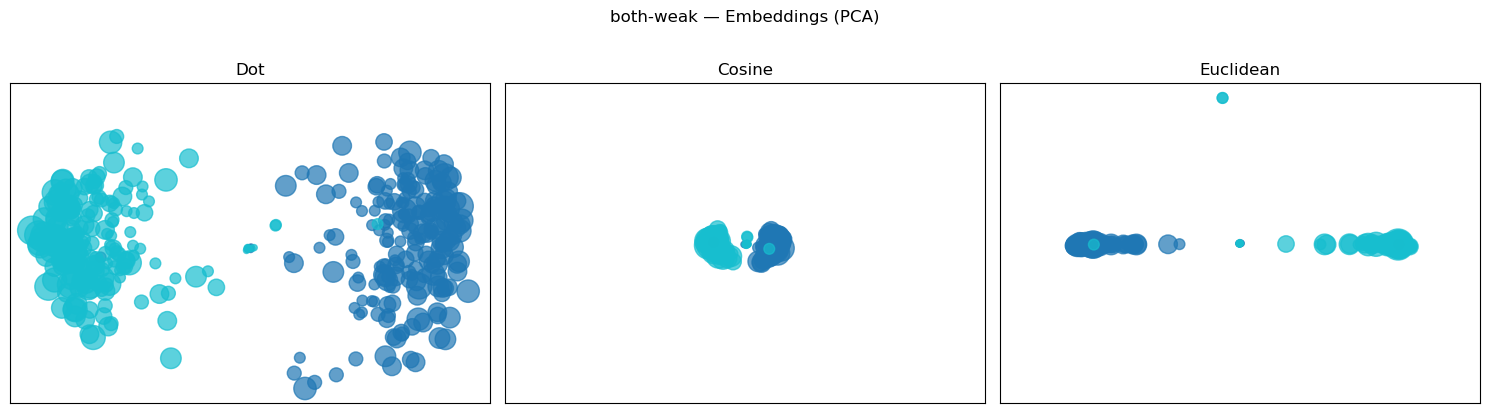

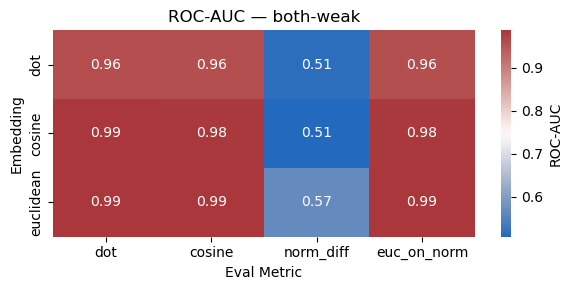

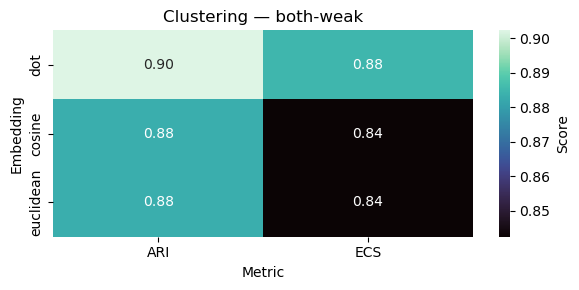

100%|█████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:11<00:00, 111.78it/s, loss=1.15]


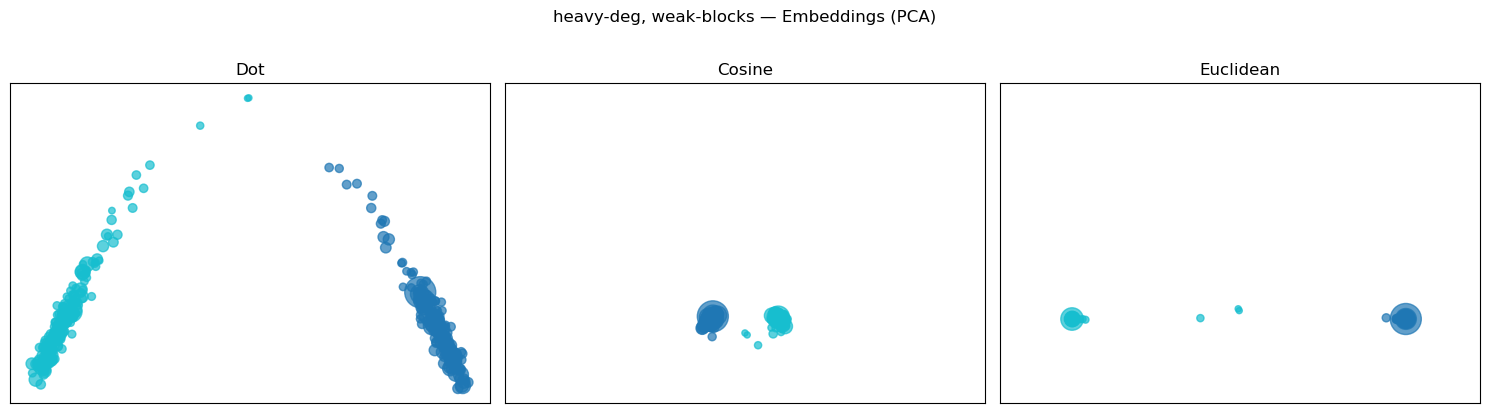

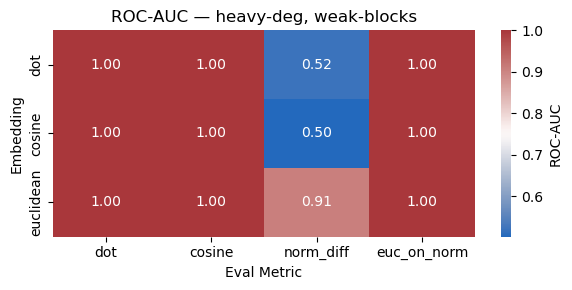

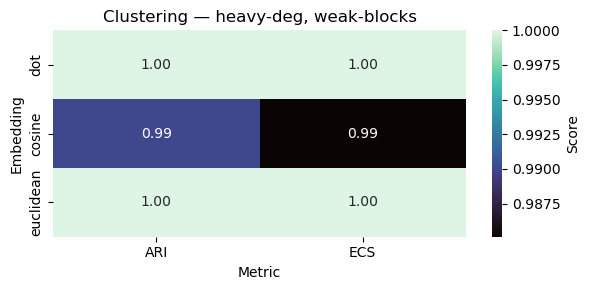

100%|█████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:11<00:00, 104.81it/s, loss=1.18]


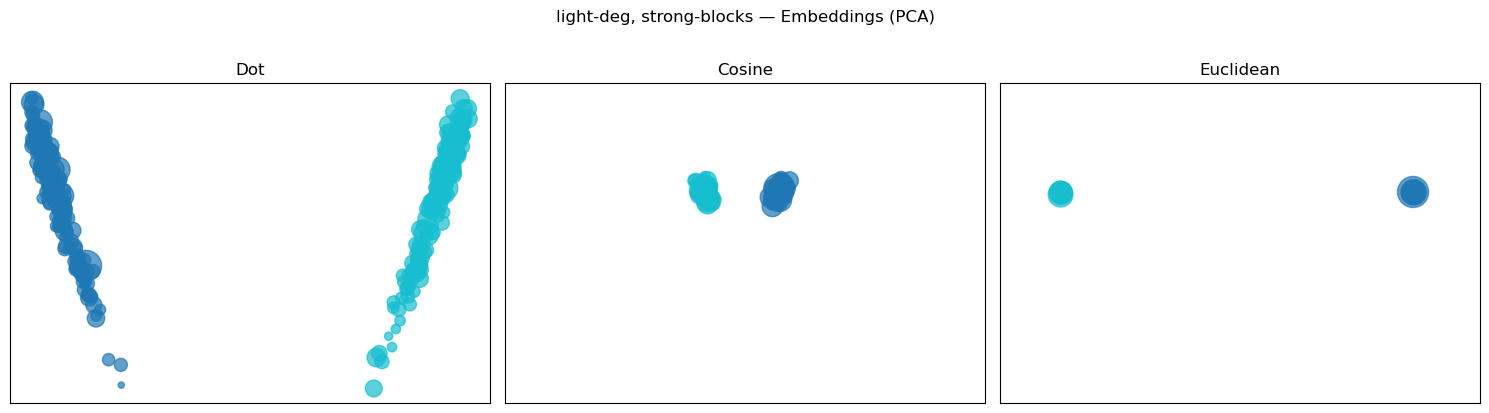

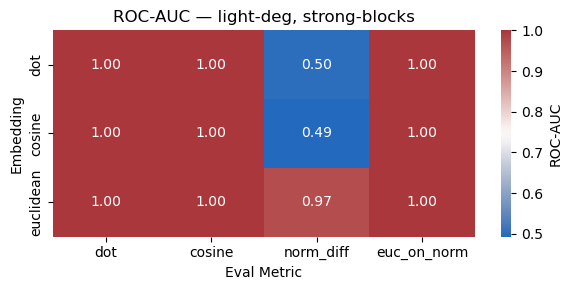

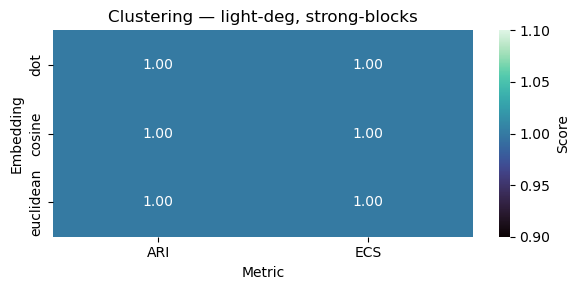

100%|█████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:11<00:00, 105.94it/s, loss=1.27]


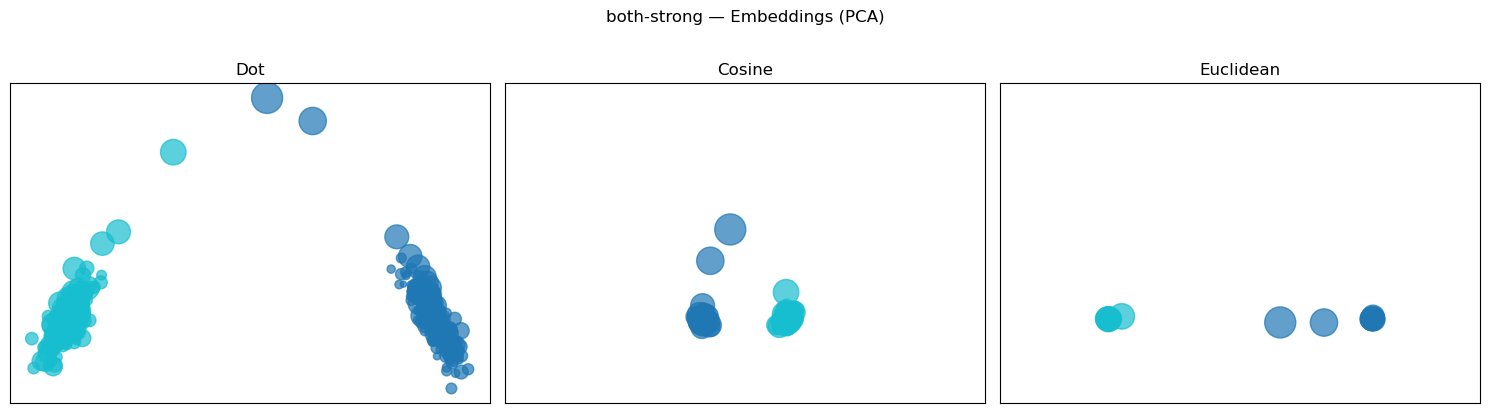

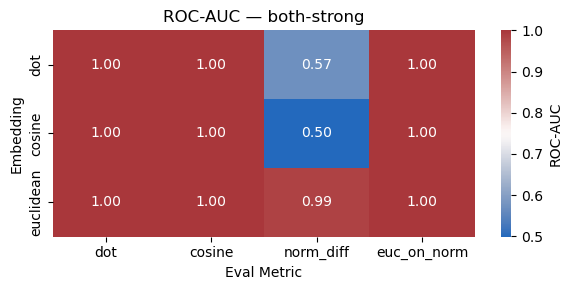

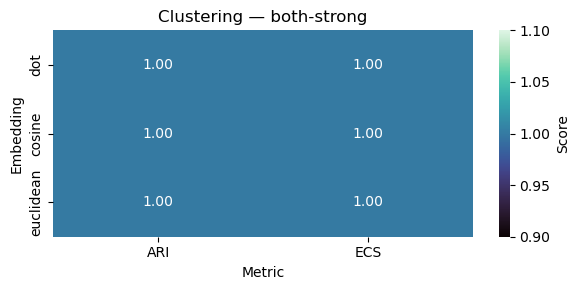

In [21]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from node2vecs import TorchNode2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, adjusted_rand_score
import scipy.sparse as sp
import pandas as pd

# --- helper functions ---

def make_dcsbm_extreme(n_per_block, alpha, B_in, B_out):
    N = 2 * n_per_block
    labels = np.zeros(N, int)
    labels[n_per_block:] = 1
    theta = np.random.pareto(alpha, size=N) + 1.0
    G = nx.Graph()
    G.add_nodes_from(range(N))
    for i in range(N):
        for j in range(i+1, N):
            p = theta[i] * theta[j] * (
                B_in if labels[i] == labels[j] else B_out
            )
            if np.random.rand() < p:
                G.add_edge(i, j)
    return G, labels, theta

def calc_esim(y, ypred):
    ylab, y = np.unique(y, return_inverse=True)
    yplab, ypred = np.unique(ypred, return_inverse=True)
    Ka, Kb = len(ylab), len(yplab)
    K = max(Ka, Kb)
    N = len(y)
    UA = sp.csr_matrix((np.ones_like(y), (np.arange(N), y)), shape=(N, K))
    UB = sp.csr_matrix((np.ones_like(ypred), (np.arange(N), ypred)), shape=(N, K))
    nA = np.array(UA.sum(axis=0)).ravel()
    nB = np.array(UB.sum(axis=0)).ravel()
    nAB = (UA.T @ UB).toarray()
    nAB_rand = np.outer(nA, nB) / N
    Q = 1 / np.maximum(np.maximum.outer(nA, nB), 1)
    S = (Q * (nAB ** 2)).sum() / N
    Srand = (Q * (nAB_rand ** 2)).sum() / N
    return (S - Srand) / (1 - Srand)

# --- scenarios in the desired order ---

scenario_order = [
    'both-weak',
    'heavy-deg, weak-blocks',
    'light-deg, strong-blocks',
    'both-strong'
]
scenarios = {
    'heavy-deg, weak-blocks':   dict(alpha=1.5, B_in=0.01,  B_out=0.0001),
    'light-deg, strong-blocks': dict(alpha=5.0, B_in=0.1,   B_out=0.001),
    'both-strong':              dict(alpha=1.5, B_in=0.1,   B_out=0.001),
    'both-weak':                dict(alpha=5.0, B_in=0.01,  B_out=0.0001),
}

# --- main loop ---

for name in scenario_order:
    params = scenarios[name]
    # build graph & embeddings
    G, labels, theta = make_dcsbm_extreme(
        n_per_block=200,
        alpha=params['alpha'],
        B_in=params['B_in'],
        B_out=params['B_out']
    )
    A = nx.to_scipy_sparse_array(G, format='csr')
    embeds = {}
    for metric in ['dot', 'cosine', 'euclidean']:
        m = TorchNode2Vec(
            vector_size=32,
            similarity_metric=metric,
            device='cpu',
            num_workers=1
        )
        m.fit(A)
        embeds[metric] = m.transform()

    # compute node sizes from degree
    degs = np.array([G.degree(i) for i in G.nodes()], float)
    dn = (degs - degs.min()) / (degs.max() - degs.min())
    sizes = 20 + dn * (500 - 20)

    # PCA plots in one row
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
    for ax, (metric, E) in zip(axes, embeds.items()):
        Z = PCA(n_components=2).fit_transform(E)
        sc = ax.scatter(
            Z[:, 0], Z[:, 1],
            c=labels, cmap='tab10',
            s=sizes, alpha=0.7
        )
        ax.set_title(metric.capitalize())
        ax.set_xticks([]); ax.set_yticks([])
    fig.suptitle(f"{name} — Embeddings (PCA)", y=1.02)
    plt.tight_layout()
    plt.show()

    # sample same/diff-block pairs
    N = len(labels)
    rng = np.random.default_rng(42)
    same = [(i, j) for i in range(N) for j in range(i+1, N) if labels[i] == labels[j]]
    diff = [(i, j) for i in range(N) for j in range(i+1, N) if labels[i] != labels[j]]
    pos = rng.choice(len(same), 10000, replace=False)
    neg = rng.choice(len(diff), 10000, replace=False)
    pairs = np.array([same[i] for i in pos] + [diff[i] for i in neg])
    y = np.array([1] * 10000 + [0] * 10000)

    # ROC-AUC heatmap
    roc_data = {}
    for metric, E in embeds.items():
        i, j = pairs[:, 0], pairs[:, 1]
        dots = (E[i] * E[j]).sum(axis=1)
        norms = np.linalg.norm(E, axis=1)
        cosines = dots / (norms[i] * norms[j] + 1e-12)
        norm_diff = -np.abs(norms[i] - norms[j])
        Eunit = E / (norms[:, None] + 1e-12)
        euc_on = -np.linalg.norm(Eunit[i] - Eunit[j], axis=1)
        roc_data[metric] = {
            'dot':         roc_auc_score(y, dots),
            'cosine':      roc_auc_score(y, cosines),
            'norm_diff':   roc_auc_score(y, norm_diff),
            'euc_on_norm': roc_auc_score(y, euc_on)
        }
    roc_df = pd.DataFrame.from_dict(roc_data).T
    plt.figure(figsize=(6, 3))
    sns.heatmap(roc_df, annot=True, fmt=".2f", cmap="vlag", cbar_kws={'label':'ROC-AUC'})
    plt.title(f"ROC-AUC — {name}")
    plt.xlabel("Eval Metric"); plt.ylabel("Embedding")
    plt.tight_layout()
    plt.show()

    # Clustering ARI/ECS heatmap
    clus_data = {}
    for metric, E in embeds.items():
        km = KMeans(n_clusters=2, random_state=0).fit(E)
        ypr = km.labels_
        clus_data[metric] = {
            'ARI': adjusted_rand_score(labels, ypr),
            'ECS': calc_esim(labels, ypr)
        }
    clus_df = pd.DataFrame.from_dict(clus_data).T
    plt.figure(figsize=(6, 3))
    sns.heatmap(clus_df, annot=True, fmt=".2f", cmap="mako", cbar_kws={'label':'Score'})
    plt.title(f"Clustering — {name}")
    plt.xlabel("Metric"); plt.ylabel("Embedding")
    plt.tight_layout()
    plt.show()


In [20]:
np.sort([i[1] for i in list(G.degree())])

array([ 36,  40,  40,  40,  41,  41,  42,  42,  42,  42,  42,  42,  43,
        43,  43,  43,  44,  44,  44,  44,  44,  44,  44,  45,  45,  45,
        45,  45,  45,  46,  46,  46,  46,  46,  46,  46,  47,  47,  47,
        47,  47,  47,  48,  48,  48,  48,  48,  49,  49,  49,  49,  49,
        49,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,
        50,  51,  51,  51,  51,  51,  51,  51,  51,  51,  51,  52,  52,
        52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  53,  53,
        53,  53,  53,  53,  53,  54,  54,  54,  54,  54,  54,  54,  55,
        55,  55,  55,  55,  55,  55,  55,  55,  55,  55,  56,  56,  56,
        56,  56,  57,  57,  57,  58,  58,  58,  58,  58,  58,  59,  59,
        59,  59,  59,  60,  60,  60,  60,  60,  60,  60,  60,  60,  60,
        60,  61,  61,  61,  61,  61,  61,  61,  62,  62,  62,  62,  62,
        62,  62,  62,  62,  63,  63,  63,  63,  63,  63,  63,  63,  64,
        64,  64,  64,  64,  64,  64,  65,  65,  65,  65,  65,  6